In [1]:
using GynC
using Plots

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in @memoize(::Expr, ::Vararg{Expr,N}) at /home/numerik/bzfsikor/.julia/v0.5/Memoize/src/Memoize.jl:19
 in include_from_node1(::String) at ./loading.jl:488 (repeats 2 times)
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:415
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/numerik/bzfsikor/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/numerik/bzfsikor/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading /home/numerik/bzfsikor/.julia/v0.5/GynC/src/eb/regularizers.jl, in expression starting on line 2


In [2]:
rho_std = 5
xs, ys, datas, zs = GynC.Federn.federexperiment(nx=300, zmult=1, ndata=200, rho_std=rho_std, xmin=1, xmax=110);
w0 = GynC.Federn.wbeta(xs, 110+0.1); # add 0.1 to circumvent 0 weight;

In [70]:
# hzuni objective - compute z entropy on uniform z grid
zunigridsize = 30
zsuni = let n=300, size=zunisize
    reshape([[x,y] for x in linspace(-size+.5, size-.5, n), y in linspace(-size+.5, size-.5, n)], n^2)
end
wzsuni = (zunisize*2)^2 / length(zsuni)

function hzuni(w)
    l = GynC.likelihoodmat(zsuni, ys, rho_std)
    rhoz = l*w
    #rhoz = rhoz/sum(rhoz)
    h=0.
    for r in rhoz
        h-= r * log(r)
    end
    h * wzsuni
end

hzuni (generic function with 1 method)

In [71]:
# different rhoz samplings
zsdict = Dict()
#for mult = [1,10,20,50,100,200,300]
for mult = [1,100,300]
   zsdict[mult] = GynC.Federn.perturb.(repmat(ys,mult), rho_std)
end

objdict = Dict()
objdict["hzuni"] = hzuni
#objdict["hzkde"] = hzkde
for (mult, z) in zsdict
    objdict["hz$mult"] = w->GynC.Hz(w, ys, z, rho_std)
end

In [72]:
ws = Dict()
niter = 20
h = 0.01

for (name, obj) in objdict
    @time ws[name] = GynC.gradientascent(obj, w0, niter, h)
end

INFO: computing likelihood matrix


108.410968 seconds (117.06 M allocations: 11.737 GB, 14.02% gc time)


INFO: computing likelihood matrix


902.891657 seconds (351.04 M allocations: 35.205 GB, 4.07% gc time)


INFO: computing likelihood matrix


  0.802318 seconds (1.20 M allocations: 121.233 MB, 17.83% gc time)


INFO: computing likelihood matrix


933.101231 seconds (512.72 M allocations: 37.614 GB, 5.70% gc time)



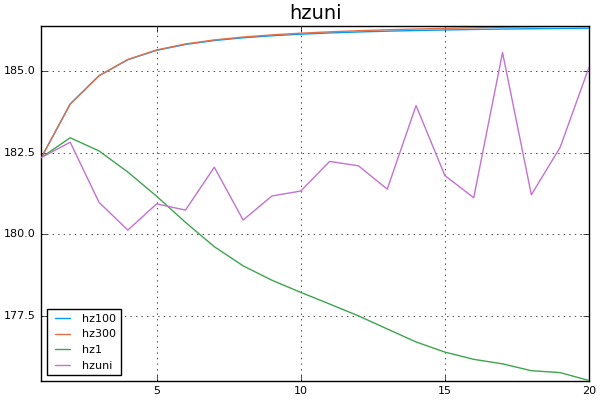

In [73]:
function objplot(obj; kwargs...)
    p = plot()
    for (k,v) in ws
        plot!(p, map(obj,v), label=k; kwargs...)
    end
    p
end

objplot(hzuni, title="hzuni")


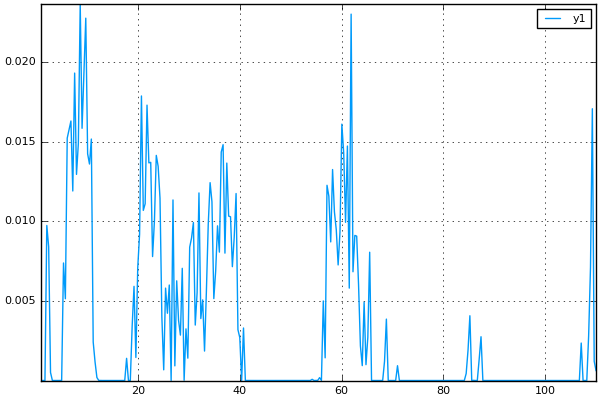

In [87]:
plot(xs,ws["hz300"][end])

In [75]:
kernel = map(x->pdf(Distributions.Normal(0,2),x), -20:20)
smoothed = conv(w, kernel)
plot(smoothed[20:320])

LoadError: LoadError: UndefVarError: pdf not defined
while loading In[75], in expression starting on line 1


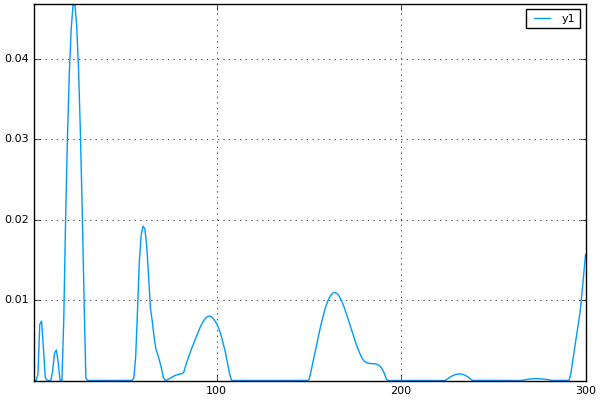

In [76]:
plot(ws["hzuni"][end])

In [77]:
# monte carlo approximation of Var(p*log(p))


function varlogrho(w, zs)
    wz = repmat(w, Int(length(zs)/length(ys))) / Int(length(zs)/length(ys))
    
    L  = GynC.likelihoodmat(zs, ys, rho_std)
    rhoz = L * w
    @show E = dot(wz,log(rhoz))
    var = dot(wz, (log(rhoz) .^ 2)) - E^2
end

function varlogrhouni(w)
    L = GynC.likelihoodmat(zsuni, ys, 5)
    rhoz = L*w
    @show E = dot(wuni * rhoz, log(rhoz))
    var = wzsuni * dot(rhoz, (log(rhoz) - E).^2)
    
end

varlogrhouni (generic function with 1 method)

In [78]:
w300=ws["hz300"][end];
wuni=ws["hzuni"][end];

In [79]:
varlogrhouni(w300)

E = dot(wuni * rhoz,log(rhoz)) = -7.455330826352638


0.61087028370713

In [80]:
varlogrhouni(wuni)

E = dot(wuni * rhoz,log(rhoz)) = -7.404719418966263


0.7348598130180934

In [81]:
varlogrho(w300, zsdict[300])

E = dot(wz,log(rhoz)) = -7.268689045882746


0.5796422526046499

In [82]:
varlogrho(wuni, zsdict[300])

E = dot(wz,log(rhoz)) = -7.195889954875573


0.6622383062420312

TODO:
-optimize d/dw A*w autodiff
-plot ws["z300"] for multiple zs
-optimize for the pen likelihood